# Ejecución de modelos en Edge-TPU (CoralAI)  
---

**Arturo Sirvent Fresneda**  
_6 de abril de 2022_  
_Master de Ciencia de Datos (UV)_  






**Referencias:**  

1. Repositorio con código muy util y similar al usado aquí.  
https://github.com/tanhouren/Face_mask_detector   
https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/TFLite_detection_webcam.py 


2. Videos de youtube:  
https://www.youtube.com/watch?v=qJMwNHQNOVU&ab_channel=EdjeElectronics  
https://www.youtube.com/watch?v=aimSGOAUI8Y&ab_channel=EdjeElectronics  


3. Websites oficiales:  
https://coral.ai/docs/edgetpu/models-intro/  
https://coral.ai/docs/edgetpu/tflite-python/#update-existing-tf-lite-code-for-the-edge-tpu

---

In [2]:
#importamos las librerias para la dereccion
#y tambien las necesarias para tflite

import numpy as np
import tensorflow as tf
import cv2
import os
import importlib.util
from threading import Thread
import logging
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from threading import Thread
import time

#! pip install playsound
#! pip install pygobject #esto no se porque
from playsound import playsound


playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
#directorio de los modelos y los datos
dir_model="/home/arturo/Documentos/MASTER_CD/Segundo_Cuatrimestre/DeepLearning/CoralAI/repositorios_terceros/mi_codigo/modelos"
dir_data="/home/arturo/Documentos/MASTER_CD/Segundo_Cuatrimestre/DeepLearning/CoralAI/repositorios_terceros/mi_codigo/datos"

labels="coco_labels.txt"
model_name_tpu="tf2_ssd_mobilenet_v2_coco17_ptq_edgetpu.tflite"
model_name_def="tf2_ssd_mobilenet_v2_coco17_ptq.tflite"

Ahora podríamos usar **PyCoral** para hacer todo el tema de la asignación de inputs requeridos, outputs obtenidos, de la asignacion del intérprete etc... Pero no me parece que vaya a hacer una gran diferencia en la cantidad de código. Mas sobre eso [aquí](https://coral.ai/docs/edgetpu/tflite-python/#overview).  
El modelo es un modelo precompilado para edge tpu que se ofrece en [la página de coralAI](https://coral.ai/models/object-detection/), pero hay muchas formas de entrenar nosotros mismo el modelo, solo se requiere que cumpla unos [requisitos](https://coral.ai/docs/edgetpu/models-intro/) para que sea posible la optimización, pasarlo a formato .tflite, cuantizarlo etc... Una vez tenemos el modelo, tenemos que aplicar la compilacion a [edge-TPU](https://coral.ai/docs/edgetpu/compiler/#system-requirements). Una vez hacemos la compilación, hay formas de visualizar el grafo y todo este tema que se crea del .tflite, también al compilar a [edge-TPU](https://coral.ai/docs/edgetpu/compiler/#system-requirements), este nos informa de cuantos procesos se han podido alocar en la TPU y cuantos quedan fuera (se corren en la TPU todos los procesos en orden hasta que se llega a uno que no se puede correr, a partir eso va a la CPU, también la última capa de clasificación de un modelo va a la CPU siempre). Aparte de lo que añadamos mediante PyCoral o simple .tflite code, tenemos que tener instalado en el sistema el [edgeTPU-runtime](https://coral.ai/docs/accelerator/get-started/#1-install-the-edge-tpu-runtime), que hace como de interfase entre el código y el hardware del USB-TPU.

In [3]:
#vamos a crear el interprete para correrlo con la tpu o sin ella
use_TPU=False
from tflite_runtime.interpreter import Interpreter
if use_TPU:
    from tflite_runtime.interpreter import load_delegate

In [4]:

# If using Edge TPU, assign filename for Edge TPU model
if use_TPU:
    GRAPH_NAME = 'edgetpu.tflite' 

In [5]:

#ahora vamos a cargar el modelo

if use_TPU:
    interpreter=Interpreter(model_path=os.path.join(dir_model,model_name_tpu),
                           experimental_delegates=[load_delegate('libedgetpu.so.1.0')])
else:
    #ambos funcionan, no se muy bien la diferencia del que viene de tflite_runtime del otro
    #pero si es importante que el modelo aqui sea el no edge.tpu
    interpreter=Interpreter(model_path=os.path.join(dir_model,model_name_def))
    #interpreter = tf.lite.Interpreter(model_path=os.path.join(dir_model,model_name))
    
#añadimos esta linea como para "inicializar con tensores el modelo"
interpreter.allocate_tensors()
    
#y de este modelo que acabamos de cargar tenemos que averiguar que parámetros nos requiere
input_details = interpreter.get_input_details()
#y que parametros nos devuelve. Esto lo usaremos mas adelante, tras declarar y ejecutar el modelo
output_details = interpreter.get_output_details()



In [6]:

#y las labels

with open('./modelos/coco_labels.txt') as f:
    coco_classes = np.array(f.read().splitlines())

Una vez que tenemos el modelo colocado, solo necesitamos obtener las imágenes de la cámara e ir metiendolas en el modelo y que este haga la predicción y así.  
Esto lo podemos hacer mediante [Threads](https://realpython.com/intro-to-python-threading/), que son ejecuciones alternadas de funciones de forma que se ejecutan casi a la vez compartiendo muchas veces información entre ellas. Esto no es concurrencia de processos, esto no es paralelización ni multiporcesado, solo que el programa cambia entre funciones muy rápido, así se puede usar en uno la información obtenida del otro. Pero como queremos mantener todo sencillo, y solo necesitamos **obtener imagen de la cámara(frame)** --> **realizar detección de objetos** --> **procesar el output de la red para tomar una acción**, esto lo podemos hacer mediante un sencillo bucle infinito _while_.  


Antes de hacer todo junto, vamos a proceder por partes para una sola imagen tomada por la cámara.  

In [7]:
#cargamos la cámara y tomamos la captura.
cam = cv2.VideoCapture(0)

#si activamos la cámara, luego debemos hacer `cam.release()` para colver a declararla
#cam.release()

In [8]:
cam.release()

In [37]:
w=cam.get(3)
h=cam.get(4)

True (480, 640, 3) uint8


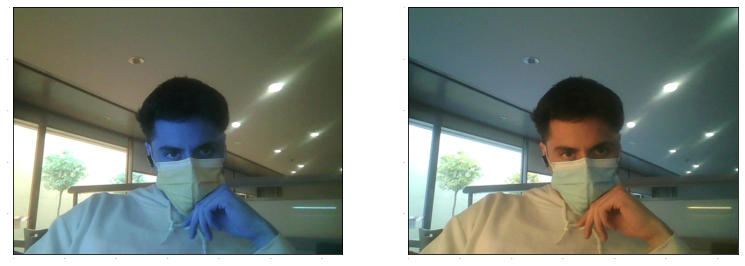

In [38]:
status,imagen=cam.read()
print(status,imagen.shape,imagen.dtype)
#la imagen tiene esa shape porque es lo estandar, pero se pueden cambiar esas cosas
#mediante `cam.set(...)`
#por ejemplo  
#cam.set(3,WIDTH)
#cam.set(4,HEIGHT)
plt.figure(figsize=(13,7))
plt.subplot(1,2,1)
plt.imshow(imagen)
plt.tick_params("both",size=0,labelsize=0)
#la imagen esta en BGR y la queremos en RGB pues es el estandar
#por eso la sobreescribimos
imagen=cv2.cvtColor(imagen,cv2.COLOR_BGR2RGB)
plt.subplot(1,2,2)
plt.imshow(imagen)
plt.tick_params("both",size=0,labelsize=0)


**Podría darse el caso quue necesitemos el input en el rango [-1,1], aunque este no es nuestro caso, este sería el procesimiento:**

Hay un problema, que si usamos la imagen de tipo _"uint8"_, cuando normalicemos, si nos pasamos de 255, se reinicia porque solo tenemos **1byte** de almacenacimiento, entonces no podemos hacer `(img*2)/255` -1 para ponerla entre -1 y 1. La solución sería, `img*(2/255)` ó hacer un cambio sobre img --> `img.astype("uint16)*2/255`


In [9]:
(imagen.astype("uint16")*2/255).dtype

#esto nos cambia el tipo a float64

dtype('float64')

[{'name': 'serving_default_input:0', 'index': 0, 'shape': array([  1, 300, 300,   3], dtype=int32), 'shape_signature': array([  1, 300, 300,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.007843137718737125, 127), 'quantization_parameters': {'scales': array([0.00784314], dtype=float32), 'zero_points': array([127], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


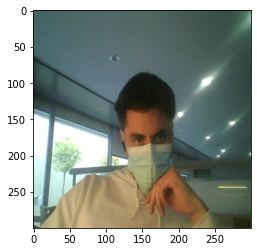

In [40]:
#hacemos par de cambios más como el tamaño y el formato
#el tamaño demandado por el modelo se ve en:
print(input_details)
shape=(input_details[0]["shape"][1],input_details[0]["shape"][2])
imagen2 = cv2.resize(imagen,shape)
plt.imshow(imagen2)

Si hubieramos cambiado el rango a [-1,+1], la imagen se vería mas oscura por los cambios que hemos hecho en los valores, pero sigue estando ahi toda la información, esto ya es problema del `plt.imshow()`.

El input que necesitamos es tipo `uint8` y con el tamaño obtenido, pero necesitamos la dimension de batch.

In [41]:
imagen3=imagen2[np.newaxis,...]
print(imagen3.shape,imagen3.dtype)

(1, 300, 300, 3) uint8


In [42]:
#ahora solo quedaria pasarle el input al modelo e "invocarlo"
interpreter.set_tensor(input_details[0]['index'], imagen3)
interpreter.invoke()

Ya se ha corrido todo el modelo, solo nos quedaría obtener los datos sobre el output. Si quisieramos TODOS los datos, del modelo, los podemos obtener en `interpreter.get_tensor_details()`, pero es mejor que saquemos solo aquello que necesitamos.  

In [115]:
#info breve sobre input e output se peude encontra en:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['input'],
  'outputs': ['output_0', 'output_1', 'output_2', 'output_3']}}

In [43]:
#info mas extensa sobre el output, en :
output_details=interpreter.get_output_details()
output_details

[{'name': 'StatefulPartitionedCall:3;StatefulPartitionedCall:2;StatefulPartitionedCall:1;StatefulPartitionedCall:02',
  'index': 252,
  'shape': array([ 1, 20], dtype=int32),
  'shape_signature': array([ 1, 20], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'StatefulPartitionedCall:3;StatefulPartitionedCall:2;StatefulPartitionedCall:1;StatefulPartitionedCall:0',
  'index': 250,
  'shape': array([ 1, 20,  4], dtype=int32),
  'shape_signature': array([ 1, 20,  4], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'StatefulPartitionedCall:3;StatefulPartitionedCall:2;StatefulPartitionedCall:1;Stateful

In [44]:
#esta informacion la he obtenido del github que se referencia al principio,
#no se si se puede intuir de la informacion de la celda anterior, yo no lo veo claro...

scores = interpreter.get_tensor(output_details[0]['index'])

boxes = interpreter.get_tensor(output_details[1]['index'])

num = interpreter.get_tensor(output_details[2]['index'])

classes = interpreter.get_tensor(output_details[3]['index'])

#output = [boxes,classes,scores,num]
print([ i.shape for i in [boxes,classes,scores,num]])
print(boxes,classes,scores,num, sep="\n")

[(1, 20, 4), (1, 20), (1, 20), (1,)]
[[[2.8110126e-01 4.7548205e-02 1.0035816e+00 8.1501865e-01]
  [2.0563130e-01 3.6063331e-01 2.3784785e-01 4.0165579e-01]
  [5.7494903e-01 8.5734159e-02 8.3328879e-01 2.2715551e-01]
  [2.0649219e-01 3.5781804e-01 2.3547670e-01 3.8680258e-01]
  [7.4981362e-01 5.1004982e-01 9.6567029e-01 7.8865302e-01]
  [6.7347306e-01 1.5439589e-01 7.7961689e-01 4.2882305e-01]
  [5.8237487e-01 6.8079360e-02 7.4195784e-01 2.5060987e-01]
  [5.7338083e-01 4.3135148e-01 8.9740360e-01 5.7932764e-01]
  [7.2517264e-01 8.6812302e-02 8.8718402e-01 3.7832862e-01]
  [8.7984437e-01 3.1312134e-02 9.6981221e-01 1.0090828e-01]
  [6.8697613e-01 3.1579816e-01 7.2501498e-01 3.7747383e-01]
  [8.3595026e-01 9.2044231e-03 9.1448414e-01 4.3427154e-02]
  [8.9040411e-01 5.5160880e-01 9.4263959e-01 5.9141076e-01]
  [9.5826328e-01 2.0653196e-04 1.0011872e+00 4.1853271e-02]
  [8.5059202e-01 5.5804774e-03 9.9000299e-01 6.8194650e-02]
  [9.4080657e-02 6.0797143e-01 9.3368495e-01 1.0031639e+00]
  [

In [45]:
coco_classes[classes[0].astype("int")]

array(['person', 'kite', 'potted plant', 'kite', 'carrot', 'chair',
       'potted plant', 'tie', 'chair', 'chair', 'person', 'bottle',
       'knife', 'car', 'chair', 'tv', 'chair', 'chair', 'knife',
       'scissors'], dtype='<U14')

In [46]:
output_probs = tf.math.softmax(scores[0])
pred_label = tf.math.argmax(output_probs)
coco_classes[classes[0].astype("int")][pred_label]

2022-04-06 19:45:23.015822: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-06 19:45:23.032111: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-06 19:45:23.038565: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


'person'

In [47]:
boxes1=boxes[0]
box_coords = np.zeros_like(boxes1)
box_coords[:, 0] = boxes1[:, 0] * h
box_coords[:, 1] = boxes1[:, 1] * w
box_coords[:, 2] = boxes1[:, 2] * h
box_coords[:, 3] = boxes1[:, 3] * w

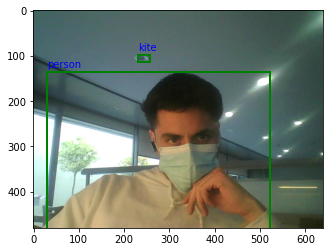

In [50]:
plt.imshow(imagen)
ax=plt.gca()

for i in range(2):
    box_h=box_coords[i,2]-box_coords[i,0]
    box_w=box_coords[i,3]-box_coords[i,1]

    rect = patches.Rectangle((box_coords[i,1], box_coords[i,0]), box_w, box_h, linewidth=2, 
                             edgecolor='g', facecolor='none')

    ax.add_patch(rect)
    ax.text(box_coords[i,1], box_coords[i,0]-10,coco_classes[classes[0].astype("int")][i],color="blue")

Vamos a añadir una acción si resulta que la detección es una manzana:   
Vamos a emitir un sonido mientas que detecte una manzana.  

In [60]:
if "person" in coco_classes[classes[0].astype("int")][0:2]: 
    playsound("nogod_crop.mp3",block=False)
    
if "person" in coco_classes[classes[0].astype("int")][0:2]: 
    playsound("like.mp3",block=False)
       
    

In [75]:
count=0
for i in range(18):
    if "person" in coco_classes[classes[0].astype("int")][0:2]: 
        playsound("like.mp3",False)
    time.sleep(0.1)
    count+=1
    if count//3==0:
        time.sleep(1)

Ahora ya podemos poner el modelo a funcionar, con unos pocos ajustes, podemos hacer que la camara este constantemente captando imágenes y clasificando los frames uno tras otro. Es aquí donde notaremos un aumento significativo del aumento del frame rate.  

# El tema del video stream....

Usamos un código sacado de [medium](https://abauville.medium.com/display-your-live-webcam-feed-in-a-jupyter-notebook-using-opencv-d01eb75921d1), en el cual usa los Threads para tener corriendo la detección de imágenes y el display.

In [17]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
import threading

# Stop button
# ================
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the `fa-` prefix)
)


# Display function
# ================
def view(button):
    cap = cv2.VideoCapture(0)
    display_handle=display(None, display_id=True)
    i = 0
    while True:
        _, frame = cap.read()
        frame = cv2.flip(frame, 1) # if your camera reverses your image
        _, frame = cv2.imencode('.jpeg', frame)
        #cv2.imshow("asdf",frame)
        display_handle.update(Image(data=frame.tobytes()))
        if stopButton.value==True:
            cap.release()
            display_handle.update(None)

            
# Run
# ================
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

None

QObject::moveToThread: Current thread (0x7f48b8194f30) is not the object's thread (0x7f48b820b450).
Cannot move to target thread (0x7f48b8194f30)

QObject::moveToThread: Current thread (0x7f48b8194f30) is not the object's thread (0x7f48b820b450).
Cannot move to target thread (0x7f48b8194f30)

QObject::moveToThread: Current thread (0x7f48b8194f30) is not the object's thread (0x7f48b820b450).
Cannot move to target thread (0x7f48b8194f30)

QObject::moveToThread: Current thread (0x7f48b8194f30) is not the object's thread (0x7f48b820b450).
Cannot move to target thread (0x7f48b8194f30)

QObject::moveToThread: Current thread (0x7f48b8194f30) is not the object's thread (0x7f48b820b450).
Cannot move to target thread (0x7f48b8194f30)

QObject::moveToThread: Current thread (0x7f48b8194f30) is not the object's thread (0x7f48b820b450).
Cannot move to target thread (0x7f48b8194f30)

QObject::moveToThread: Current thread (0x7f48b8194f30) is not the object's thread (0x7f48b820b450).
Cannot move to tar

In [21]:
#Código muchisimo mas sencillo para obtener frames
#vamos a añadir el código de procesado y prediccion de la imagen aqui dentro

capture = cv2.VideoCapture(0)
w=capture.get(3)
h=capture.get(4)
while True:
    ret, frame = capture.read()
    imagen=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB )
    shape=(input_details[0]["shape"][1],input_details[0]["shape"][2])
    imagen2 = cv2.resize(imagen,shape)
    imagen3=imagen2[np.newaxis,...]
    interpreter.set_tensor(input_details[0]['index'], imagen3)
    interpreter.invoke()
    
    scores = interpreter.get_tensor(output_details[0]['index'])

    boxes = interpreter.get_tensor(output_details[1]['index'])

    num = interpreter.get_tensor(output_details[2]['index'])

    classes = interpreter.get_tensor(output_details[3]['index'])

    boxes1=boxes[0]
    box_coords = np.zeros_like(boxes1)
    box_coords[:, 0] = boxes1[:, 0] * h
    box_coords[:, 1] = boxes1[:, 1] * w
    box_coords[:, 2] = boxes1[:, 2] * h
    box_coords[:, 3] = boxes1[:, 3] * w
    
    plt.imshow(imagen)
    ax=plt.gca()

    for i in range(2):
        box_h=box_coords[i,2]-box_coords[i,0]
        box_w=box_coords[i,3]-box_coords[i,1]

        rect = patches.Rectangle((box_coords[i,1], box_coords[i,0]), box_w, box_h, linewidth=2, 
                                 edgecolor='g', facecolor='none')

        ax.add_patch(rect)
        ax.text(box_coords[i,1], box_coords[i,0]-10,coco_classes[classes[0].astype("int")][i],color="blue")
    fig=plt.gcf()
    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    rgba = np.asarray(canvas.buffer_rgba())

    cv2.imshow('webCam',rgba)
    plt.close()
    if (cv2.waitKey(1) == ord('s')):
        break

capture.release()
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x55e6143d8080) is not the object's thread (0x55e61148ad40).
Cannot move to target thread (0x55e6143d8080)

QObject::moveToThread: Current thread (0x55e6143d8080) is not the object's thread (0x55e61148ad40).
Cannot move to target thread (0x55e6143d8080)

QObject::moveToThread: Current thread (0x55e6143d8080) is not the object's thread (0x55e61148ad40).
Cannot move to target thread (0x55e6143d8080)

QObject::moveToThread: Current thread (0x55e6143d8080) is not the object's thread (0x55e61148ad40).
Cannot move to target thread (0x55e6143d8080)

QObject::moveToThread: Current thread (0x55e6143d8080) is not the object's thread (0x55e61148ad40).
Cannot move to target thread (0x55e6143d8080)

QObject::moveToThread: Current thread (0x55e6143d8080) is not the object's thread (0x55e61148ad40).
Cannot move to target thread (0x55e6143d8080)

QObject::moveToThread: Current thread (0x55e6143d8080) is not the object's thread (0x55e61148ad40).
Cannot move to tar

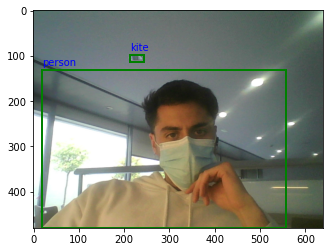

In [11]:
plt.imshow(imagen)
ax=plt.gca()

for i in range(2):
    box_h=box_coords[i,2]-box_coords[i,0]
    box_w=box_coords[i,3]-box_coords[i,1]

    rect = patches.Rectangle((box_coords[i,1], box_coords[i,0]), box_w, box_h, linewidth=2, 
                             edgecolor='g', facecolor='none')

    ax.add_patch(rect)
    ax.text(box_coords[i,1], box_coords[i,0]-10,coco_classes[classes[0].astype("int")][i],color="blue")


In [19]:
from matplotlib.backends.backend_agg import FigureCanvasAgg
canvas = FigureCanvasAgg(fig)
canvas.draw()
rgba = np.asarray(canvas.buffer_rgba())


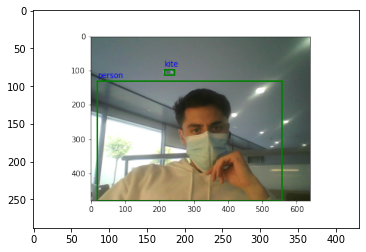

In [20]:
plt.imshow(rgba)

De uno del os repositorios he sacado esta funcion que crea el objeto videostream y hace mucho mas facil manejar todo el tema de obtener frames!!!

In [3]:
# Define VideoStream class to handle streaming of video from webcam in separate processing thread
# Source - Adrian Rosebrock, PyImageSearch: https://www.pyimagesearch.com/2015/12/28/increasing-raspberry-pi-fps-with-python-and-opencv/
class VideoStream:
    """Camera object that controls video streaming from the Picamera"""
    def __init__(self,resolution=(640,480),framerate=30):
        # Initialize the PiCamera and the camera image stream
        self.stream = cv2.VideoCapture(0)
        ret = self.stream.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'MJPG'))
        ret = self.stream.set(3,resolution[0])
        ret = self.stream.set(4,resolution[1])

        # Read first frame from the stream
        (self.grabbed, self.frame) = self.stream.read()

    # Variable to control when the camera is stopped
        self.stopped = False

    def start(self):
    # Start the thread that reads frames from the video stream
        Thread(target=self.update,args=()).start()
        return self

    def update(self):
        # Keep looping indefinitely until the thread is stopped
        while True:
            # If the camera is stopped, stop the thread
            if self.stopped:
                # Close camera resources
                self.stream.release()
                return

            # Otherwise, grab the next frame from the stream
            (self.grabbed, self.frame) = self.stream.read()

    def read(self):
    # Return the most recent frame
        return self.frame

    def stop(self):
    # Indicate that the camera and thread should be stopped
        self.stopped = True
        #self.stream.release()

In [12]:
#para usar lo anterior

# Initialize video stream
videostream = VideoStream(resolution=(600,300),framerate=30).start()
time.sleep(1)

In [23]:
videostream.stop()

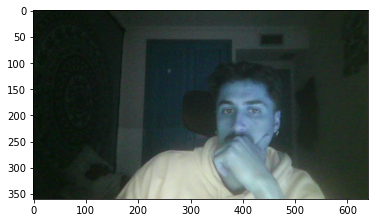

In [13]:
#y ahora podemos sacar los frames cuando los necesitemos
frame1 = videostream.read()
plt.imshow(frame1)

In [14]:
width, height=(input_details[0]["shape"][1],input_details[0]["shape"][2])


In [4]:
#pero para tener las imagenes formatedas como necesitamos vamos a englobarlo todo en una funcion
def get_img(width, height):
    frame1 = videostream.read()
    frame = frame1.copy()
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_resized = cv2.resize(frame_rgb, (width, height))
    input_data = np.expand_dims(frame_resized, axis=0)
    return input_data

In [ ]:

aux=get_img(width, height)
print(aux.shape,aux.dtype)
plt.imshow(aux[0])

#  TODO LO IMPORTANTE DEL MODELO FINAL

In [1]:
#importamos las librerias para la deteccion
#y tambien las necesarias para tflite

import numpy as np
import tensorflow as tf
import cv2
import os
import importlib.util
from threading import Thread
import logging
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from threading import Thread
import time

#! pip install playsound
#! pip install pygobject #esto no se porque
from playsound import playsound


playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
# Define VideoStream class to handle streaming of video from webcam in separate processing thread
# Source - Adrian Rosebrock, PyImageSearch: https://www.pyimagesearch.com/2015/12/28/increasing-raspberry-pi-fps-with-python-and-opencv/
class VideoStream:
    """Camera object that controls video streaming from the Picamera"""
    def __init__(self,resolution=(640,480),framerate=30):
        # Initialize the PiCamera and the camera image stream
        self.stream = cv2.VideoCapture(0)
        ret = self.stream.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'MJPG'))
        ret = self.stream.set(3,resolution[0])
        ret = self.stream.set(4,resolution[1])

        # Read first frame from the stream
        (self.grabbed, self.frame) = self.stream.read()

    # Variable to control when the camera is stopped
        self.stopped = False

    def start(self):
    # Start the thread that reads frames from the video stream
        Thread(target=self.update,args=()).start()
        return self

    def update(self):
        # Keep looping indefinitely until the thread is stopped
        while True:
            # If the camera is stopped, stop the thread
            if self.stopped:
                # Close camera resources
                self.stream.release()
                return

            # Otherwise, grab the next frame from the stream
            (self.grabbed, self.frame) = self.stream.read()

    def read(self):
    # Return the most recent frame
        return self.frame

    def stop(self):
    # Indicate that the camera and thread should be stopped
        self.stopped = True
        #self.stream.release()

In [3]:
#por último hacemos un bucle constante que prediga sobre la imagen y la enseñe

#vamos a redefinir todo lo del modelo para que esta celda sea autocontenida
#directorio de los modelos y los datos
dir_model="./modelos"
dir_data="./datos"

labels="coco_labels.txt"
model_name_tpu="tf2_ssd_mobilenet_v2_coco17_ptq_edgetpu.tflite"
model_name_def="tf2_ssd_mobilenet_v2_coco17_ptq.tflite"


#vamos a crear el interprete para correrlo con la tpu o sin ella
use_TPU=True
from tflite_runtime.interpreter import Interpreter
if use_TPU:
    from tflite_runtime.interpreter import load_delegate
# If using Edge TPU, assign filename for Edge TPU model
if use_TPU:
    GRAPH_NAME = 'edgetpu.tflite' 
#ahora vamos a cargar el modelo

if use_TPU:
    interpreter=Interpreter(model_path=os.path.join(dir_model,model_name_tpu),
                           experimental_delegates=[load_delegate('libedgetpu.so.1.0')])
else:
    #ambos funcionan, no se muy bien la diferencia del que viene de tflite_runtime del otro
    #pero si es importante que el modelo aqui sea el no edge.tpu
    interpreter=Interpreter(model_path=os.path.join(dir_model,model_name_def))
    #interpreter = tf.lite.Interpreter(model_path=os.path.join(dir_model,model_name))
    
#añadimos esta linea como para "inicializar con tensores el modelo"
interpreter.allocate_tensors()
    
#y de este modelo que acabamos de cargar tenemos que averiguar que parámetros nos requiere
input_details = interpreter.get_input_details()
#y que parametros nos devuelve. Esto lo usaremos mas adelante, tras declarar y ejecutar el modelo
output_details = interpreter.get_output_details()


#y las labels

with open('./modelos/coco_labels.txt') as f:
    coco_classes = np.array(f.read().splitlines())
    
width, height=(input_details[0]["shape"][1],input_details[0]["shape"][2])

In [4]:
resW,resH=640,480
videostream = VideoStream(resolution=(resW,resH),framerate=30).start()
time.sleep(1)

In [30]:
#videostream.stop()

In [5]:

#añadimos unas lineas para calcular el framerate
min_conf_threshold=0.7

imW, imH = int(resW), int(resH)
frame_rate_calc = 1
freq = cv2.getTickFrequency()

#con un buen framerate, vamos a registrar todas las lecturas cada 300 detecciones, si phone esta mas de la mitad,
#ejecutamos un audio
last_detections=[]
palabra="cell phone"
umbral1=140
umbral2=umbral1//2

#añadimos un contador para que deje unos pocos hasta la proxima vez
contar_repe=0 #esto queda pendiente
while True:

    # Start timer (for calculating frame rate)
    t1 = cv2.getTickCount()

    # Grab frame from video stream
    frame1 = videostream.read()
    frame = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
    frame = frame1.copy()
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_resized = cv2.resize(frame_rgb, (width, height))
    input_data = np.expand_dims(frame_resized, axis=0)
    
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    
    scores = interpreter.get_tensor(output_details[0]['index'])[0]

    boxes = interpreter.get_tensor(output_details[1]['index'])[0]

    num = interpreter.get_tensor(output_details[2]['index'])[0]

    classes = interpreter.get_tensor(output_details[3]['index'])[0]

    
    # Loop over all detections and draw detection box if confidence is above minimum threshold
    for i in range(len(scores)):
        if ((scores[i] > min_conf_threshold) and (scores[i] <= 1.0)):

            # Get bounding box coordinates and draw box
            # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
            ymin = int(max(1,(boxes[i][0] * imH)))
            xmin = int(max(1,(boxes[i][1] * imW)))
            ymax = int(min(imH,(boxes[i][2] * imH)))
            xmax = int(min(imW,(boxes[i][3] * imW)))
            
            cv2.rectangle(frame, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)

            # Draw label
            object_name = coco_classes[int(classes[i])] # Look up object name from "labels" array using class index
            #guardamos las ultimas detecciones
            last_detections.append(str(object_name))
            
            label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'person: 72%'
            labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) # Get font size
            label_ymin = max(ymin, labelSize[1] + 10) # Make sure not to draw label too close to top of window
            cv2.rectangle(frame, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED) # Draw white box to put label text in
            cv2.putText(frame, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text
    #cada 300 frames, comprobamos si una palabra clave esta almenos la mitad de las veces en la lista de
    #objetos detectados, y cada 300 volvemos a empezar
    if len(last_detections)>umbral1:
        last_detections=[]
    elif len(last_detections)!=0:
        veces_repe=sum([palabra==i for i in last_detections])
        if veces_repe>umbral2:
            playsound("./datos/nogod_crop.mp3",block=False)
            last_detections=[]

    
  
    # Draw framerate in corner of frame
    cv2.putText(frame,'FPS: {0:.2f}'.format(frame_rate_calc),(30,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,0),2,cv2.LINE_AA)

    # All the results have been drawn on the frame, so it's time to display it.
    cv2.imshow('Object detector', frame)

    # Calculate framerate
    t2 = cv2.getTickCount()
    time1 = (t2-t1)/freq
    frame_rate_calc= 1/time1

    # Press 'q' to quit
    if cv2.waitKey(1) == ord('q'):
        break

cv2.destroyAllWindows()
videostream.stop()

QObject::moveToThread: Current thread (0x557f3bfae780) is not the object's thread (0x557f3c569a30).
Cannot move to target thread (0x557f3bfae780)

QObject::moveToThread: Current thread (0x557f3bfae780) is not the object's thread (0x557f3c569a30).
Cannot move to target thread (0x557f3bfae780)

QObject::moveToThread: Current thread (0x557f3bfae780) is not the object's thread (0x557f3c569a30).
Cannot move to target thread (0x557f3bfae780)

QObject::moveToThread: Current thread (0x557f3bfae780) is not the object's thread (0x557f3c569a30).
Cannot move to target thread (0x557f3bfae780)

QObject::moveToThread: Current thread (0x557f3bfae780) is not the object's thread (0x557f3c569a30).
Cannot move to target thread (0x557f3bfae780)

QObject::moveToThread: Current thread (0x557f3bfae780) is not the object's thread (0x557f3c569a30).
Cannot move to target thread (0x557f3bfae780)

QObject::moveToThread: Current thread (0x557f3bfae780) is not the object's thread (0x557f3c569a30).
Cannot move to tar